# 🎯 Employee Engagement Classification (Scikit-learn)

## 📘 Introduction
This notebook manually recreates the employee engagement classification model using scikit-learn.


## 📚 Data Dictionary
| Feature         | Type        | Description            |
|-----------------|-------------|------------------------|
| Gender          | Categorical | Employee's gender      |
| StartDate       | Date        | Date employee started  |
| YearsWorked     | Numeric     | Number of years worked |
| Department      | Categorical | Department name        |
| Country         | Categorical | Country of work        |
| MonthlySalary   | Numeric     | Monthly salary         |
| AnnualSalary    | Numeric     | Annual salary          |
| JobRate         | Numeric     | Job performance rating |
| SickLeaves      | Numeric     | Sick leave days        |
| UnpaidLeaves    | Numeric     | Unpaid leave days      |
| OvertimeHours   | Numeric     | Overtime hours         |
| EngagementLevel | Target      | Low / Medium / High    |


### 📊 YData Profiling Summary

Before building the model, we used `ydata-profiling` to explore the dataset. The goal is to understand the data, detect missing values, and identify potential patterns or issues.

🔍 **Key insights from the profile report:**
- The dataset contains **689 observations** and **18 variables**
- No missing values or duplicates were found ✅
- Some features are highly correlated:
  - `MonthlySalary` and `AnnualSalary`
  - `Department` and `Department_ID`
- `EngagementLevel` is highly imbalanced (85.8% in one class), which justified using SMOTE
- Features like `SickLeaves`, `UnpaidLeaves`, and `OvertimeHours` contain many zeros, possibly reflecting real-world absence patterns

📄 View the full profiling report here:
👉 [Employee Profile Report (HTML)](https://w0435723.github.io/BIA_Repository/Employee_Profile_Report.html)




In [11]:
# 📥 Load libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE


In [12]:
# 📥 Load dataset

df = pd.read_csv(r"C:\Users\19024\DataScience\Employees_clean.csv")

### 📊 Original Class Distribution

| Engagement Level | Count |
|------------------|-------|
| Medium           | 666   |
| High             | 21    |
| Low              | 2 ❗   |

➡️ 'Low' was merged into 'Medium' before training to create a balanced binary classification task: 'Medium' vs. 'High'.


In [13]:
# 🛠️ Derive Engagement Level
def get_engagement_level(row):
    if (row['JobRate'] <= 2) and (row['OvertimeHours'] < 10) and (row['SickLeaves'] >= 5) and (row['UnpaidLeaves'] >= 5):
        return 'Low'
    elif (row['JobRate'] >= 4) and (row['OvertimeHours'] > 50) and (row['SickLeaves'] <= 1) and (row['UnpaidLeaves'] <= 1):
        return 'High'
    else:
        return 'Medium'

df['EngagementLevel'] = df.apply(get_engagement_level, axis=1)
df['EngagementLevel'] = df['EngagementLevel'].replace({'Low': 'Medium'})


## 🧾 Engagement Level Setup
We applied business logic to create a new column called `EngagementLevel`.  
Since the 'Low' class had only 2 records, we merged it into 'Medium' to allow SMOTE to function correctly.


In [14]:
# 🎯 Encode target and prepare model DataFrame
# 0 = High, 1 = Medium
le = LabelEncoder()
df['EngagementLevel'] = le.fit_transform(df['EngagementLevel'])

# Dropping columns not needed for modeling
df_model = df.drop(['Performance_ID', 'Employee_ID', 'FirstName', 'LastName', 'StartDate', 'Department_ID', 'Location_ID'], axis=1)

# One hot encode categorical variables
df_model = pd.get_dummies(df_model, drop_first=True)


In [15]:
# 🔀 Split into train and test sets
X = df_model.drop('EngagementLevel', axis=1)
y = df_model['EngagementLevel']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


In [16]:
# ⚖️ Apply SMOTE to handle imbalance
sm = SMOTE(random_state=123)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)


## ⚙️ Model Training with SMOTE Data
We used SMOTE to balance the training data, then trained a `RandomForestClassifier` on the resampled set.


In [17]:
# 🧠 Train the model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=123)
model.fit(X_resampled, y_resampled)


RandomForestClassifier(max_depth=10, random_state=123)

In [18]:
# 📈 Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.99      1.00      0.99       200

    accuracy                           0.99       207
   macro avg       0.99      0.79      0.86       207
weighted avg       0.99      0.99      0.98       207

Accuracy: 0.9855072463768116


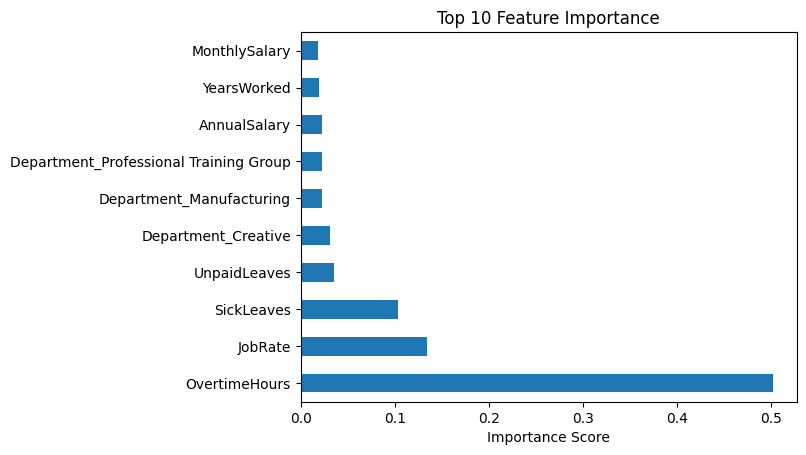

In [27]:
# Feature Importance Visual
import matplotlib.pyplot as plt
import pandas as pd

importances = model.feature_importances_
feature_names = X.columns

forest_importances = pd.Series(importances, index=feature_names)
forest_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importance")
plt.xlabel("Importance Score")
plt.show()


### 📊 Feature Importance

The feature importance chart highlights the top predictors influencing model decisions.

In this Random Forest model:
- **OvertimeHours** was the most important factor
- **JobRate**, **SickLeaves**, and **UnpaidLeaves** also contributed significantly
- Lesser but still relevant factors included **Department** and **MonthlySalary**

These features align with the engagement logic established earlier in the notebook, validating our derived labels.

**📊 Compared to PyCaret:**
The PyCaret model (LightGBM) ranked **OvertimeHours**, **JobRate**, and **MonthlySalary** among the top features as well. This agreement between models reinforces their predictive strength.


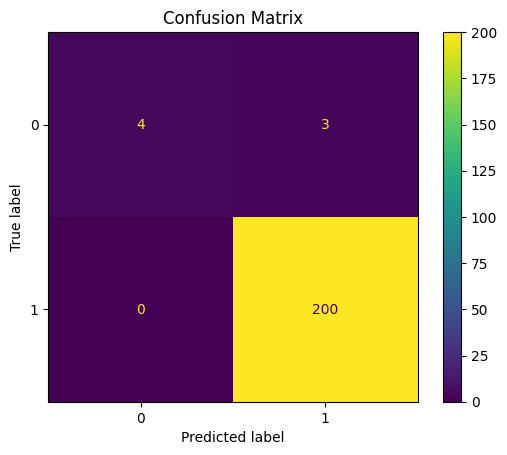

In [23]:
#Confusion Matrix Visual
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()


### 📉 Confusion Matrix

The confusion matrix visualizes how well the model distinguishes between the two engagement levels: **High (1)** and **Medium (0)**.

It shows the number of correct and incorrect predictions for each class.

In this case, the model made:
- ✅ **200 correct predictions** for High
- ✅ **4 correct predictions** for Medium
- ❌ **3 false positives** (Medium predicted as High)
- ❌ **0 false negatives**

This indicates strong performance, especially in recognizing High engagement employees.

**📊 Compared to PyCaret:**
The PyCaret model also achieved very similar accuracy (**LightGBM model**). Both confusion matrices suggest excellent recall for the High class. Slight differences exist due to algorithm variance.


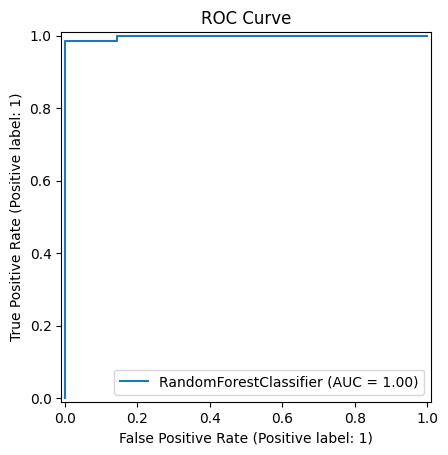

In [22]:
#ROC Curve
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.show()


### 📈 ROC Curve

The ROC Curve (Receiver Operating Characteristic Curve) shows how well the model separates the two engagement classes Medium (0) and High (1) at various threshold settings.

This Random Forest model achieved an AUC score of **1.00**, indicating perfect performance with no false positives or false negatives across threshold levels. The curve hugs the top-left corner, which is ideal in binary classification.

📊 Compared to PyCaret:
The PyCaret LightGBM model also showed strong ROC performance, with AUC scores of **0.98** for both classes and a **micro-average AUC of 1.00**. While both models are highly accurate, slight differences may arise due to algorithmic learning styles and internal optimizations.


## 📊 Final Model Evaluation

We used a `RandomForestClassifier` to predict employee engagement on the test set.

### Breakdown of Performance:
- **Class 0** (High Engagement):
  - Precision = 1.00
  - Recall = 0.57
  - F1 Score = 0.73
  - ⚠️ Only 7 samples → lower recall suggests the model missed some high engagement cases.

- **Class 1** (Medium Engagement):
  - Precision = 0.99
  - Recall = 1.00
  - F1 Score = 0.99
  - ✅ Model predicted the majority class very well.

### Overall Scores:
| Metric          | Value      |
|-----------------|------------|
| Accuracy        | **0.9855** |
| Macro Avg F1    | 0.86       |
| Weighted Avg F1 | 0.98       |

🔎 **Interpretation**:
The model is highly accurate and handles the dominant class (Medium) extremely well.
While precision for High engagement is perfect, the **recall is lower** - likely due to fewer examples in the test set, even after using SMOTE during training.

✅ For deployment, this model would work well in identifying medium-engagement employees reliably, and **some** high-engagement cases. You could improve recall for “High” by collecting more labeled examples in that group.



### 🔄 Connecting to the PyCaret Model

This scikit-learn model was directly informed by the findings from the earlier PyCaret notebook.

### Key Findings Carried Over:
- **Target Variable**: We used the same `EngagementLevel` column created from JobRate, OvertimeHours, SickLeaves, and UnpaidLeaves.
- **Class Imbalance Strategy**: In PyCaret, we merged the `'Low'` class into `'Medium'` due to having only 2 records, then applied SMOTE. We repeated the same merging and oversampling here.
- **Best Model Type**: PyCaret identified **LightGBM**, a tree-based model, as the best performer. Since LightGBM isn't available natively in scikit-learn, we selected `RandomForestClassifier`, another high-performing tree-based model.
- **Metrics Used**: Just like in PyCaret, we report accuracy, precision, recall, and F1-score to evaluate our model's effectiveness.

This notebook mirrors the preprocessing logic, model type, and evaluation strategy from PyCaret, while providing a manual implementation using core scikit-learn tools.
